In [2]:
import torch
import torchvision.models as models

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Preparing Data

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(224), #resized for alexnet
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


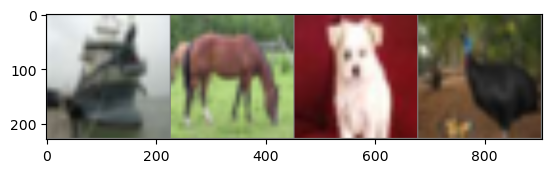

 ship horse   dog  bird


In [6]:
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
#images, labels = dataiter.next()
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Group Normalization

## Default Pooling + ReLU

In [7]:
def group_norm_layer(num_channels):
    return nn.GroupNorm(num_groups=8, num_channels=num_channels)

In [10]:
alexnet = models.alexnet(pretrained=True)
num_classes = 10
alexnet.classifier[6] = nn.Linear(alexnet.classifier[6].in_features, num_classes)

In [11]:
new_features = []

#Modify to add the GroupNorm to the alexnet after conv2d layer
for layer in alexnet.features:
    new_features.append(layer)
    # If the layer is conv2d, add GroupNorm
    if isinstance(layer, nn.Conv2d):
        new_features.append(group_norm_layer(layer.out_channels))

#Replace the original with the modified features
alexnet.features = nn.Sequential(*new_features)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
alexnet.to(device)

cuda:0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): GroupNorm(8, 64, eps=1e-05, affine=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): GroupNorm(8, 192, eps=1e-05, affine=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): GroupNorm(8, 384, eps=1e-05, affine=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): GroupNorm(8, 256, eps=1e-05, affine=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): GroupNorm(8, 256, eps=1e-05, affine=True)
    (16): ReLU(inplace=True)
    (17): Max

In [13]:
# Use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# Use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9) 

In [14]:
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = alexnet(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 2.226
[epoch: 0, i:   199] avg mini-batch loss: 2.007
[epoch: 0, i:   299] avg mini-batch loss: 1.943
[epoch: 0, i:   399] avg mini-batch loss: 1.873
[epoch: 0, i:   499] avg mini-batch loss: 1.723
[epoch: 0, i:   599] avg mini-batch loss: 1.766
[epoch: 0, i:   699] avg mini-batch loss: 1.728
[epoch: 0, i:   799] avg mini-batch loss: 1.732
[epoch: 0, i:   899] avg mini-batch loss: 1.722
[epoch: 0, i:   999] avg mini-batch loss: 1.715
[epoch: 0, i:  1099] avg mini-batch loss: 1.681
[epoch: 0, i:  1199] avg mini-batch loss: 1.669
[epoch: 0, i:  1299] avg mini-batch loss: 1.608
[epoch: 0, i:  1399] avg mini-batch loss: 1.574
[epoch: 0, i:  1499] avg mini-batch loss: 1.696
[epoch: 0, i:  1599] avg mini-batch loss: 1.557
[epoch: 0, i:  1699] avg mini-batch loss: 1.557
[epoch: 0, i:  1799] avg mini-batch loss: 1.480
[epoch: 0, i:  1899] avg mini-batch loss: 1.457
[epoch: 0, i:  1999] avg mini-batch loss: 1.546
[epoch: 0, i:  2099] avg mini-batch loss

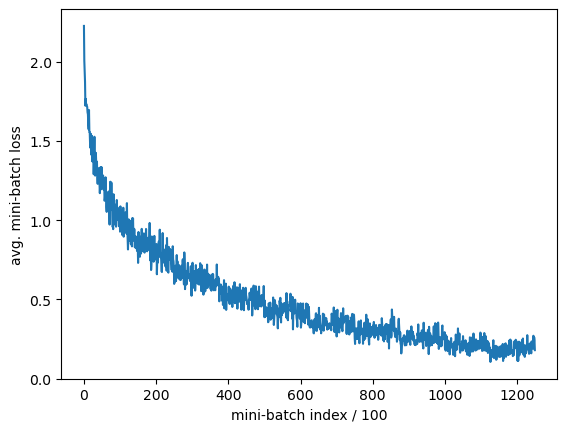

In [15]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [16]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 85 %


In [17]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 88 %
Accuracy of   car : 93 %
Accuracy of  bird : 87 %
Accuracy of   cat : 69 %
Accuracy of  deer : 88 %
Accuracy of   dog : 85 %
Accuracy of  frog : 84 %
Accuracy of horse : 87 %
Accuracy of  ship : 91 %
Accuracy of truck : 88 %


## Average Pooling + ReLU

In [18]:
alexnet = models.alexnet(pretrained=True)
num_classes = 10
alexnet.classifier[6] = nn.Linear(alexnet.classifier[6].in_features, num_classes)
for i, layer in enumerate(alexnet.features):
    if isinstance(layer, nn.MaxPool2d):
        alexnet.features[i] = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)

new_features = []

#Modify to add the GroupNorm to the alexnet after conv2d layer
for layer in alexnet.features:
    new_features.append(layer)
    # If the layer is conv2d, add GroupNorm
    if isinstance(layer, nn.Conv2d):
        new_features.append(group_norm_layer(layer.out_channels))

#Replace the original with the modified features
alexnet.features = nn.Sequential(*new_features)

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
alexnet.to(device)

cuda:0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): GroupNorm(8, 64, eps=1e-05, affine=True)
    (2): ReLU(inplace=True)
    (3): AvgPool2d(kernel_size=3, stride=2, padding=1)
    (4): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): GroupNorm(8, 192, eps=1e-05, affine=True)
    (6): ReLU(inplace=True)
    (7): AvgPool2d(kernel_size=3, stride=2, padding=1)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): GroupNorm(8, 384, eps=1e-05, affine=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): GroupNorm(8, 256, eps=1e-05, affine=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): GroupNorm(8, 256, eps=1e-05, affine=True)
    (16): ReLU(inplace=True)
    (17): AvgPool2d(kernel_size=3, stride=2, padding=1)
  )
  (avgpool)

In [20]:
# Use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# Use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9) 

In [21]:
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = alexnet(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 2.331
[epoch: 0, i:   199] avg mini-batch loss: 2.045
[epoch: 0, i:   299] avg mini-batch loss: 1.937
[epoch: 0, i:   399] avg mini-batch loss: 1.876
[epoch: 0, i:   499] avg mini-batch loss: 1.883
[epoch: 0, i:   599] avg mini-batch loss: 1.842
[epoch: 0, i:   699] avg mini-batch loss: 1.768
[epoch: 0, i:   799] avg mini-batch loss: 1.751
[epoch: 0, i:   899] avg mini-batch loss: 1.757
[epoch: 0, i:   999] avg mini-batch loss: 1.781
[epoch: 0, i:  1099] avg mini-batch loss: 1.774
[epoch: 0, i:  1199] avg mini-batch loss: 1.697
[epoch: 0, i:  1299] avg mini-batch loss: 1.648
[epoch: 0, i:  1399] avg mini-batch loss: 1.624
[epoch: 0, i:  1499] avg mini-batch loss: 1.651
[epoch: 0, i:  1599] avg mini-batch loss: 1.561
[epoch: 0, i:  1699] avg mini-batch loss: 1.622
[epoch: 0, i:  1799] avg mini-batch loss: 1.590
[epoch: 0, i:  1899] avg mini-batch loss: 1.570
[epoch: 0, i:  1999] avg mini-batch loss: 1.561
[epoch: 0, i:  2099] avg mini-batch loss

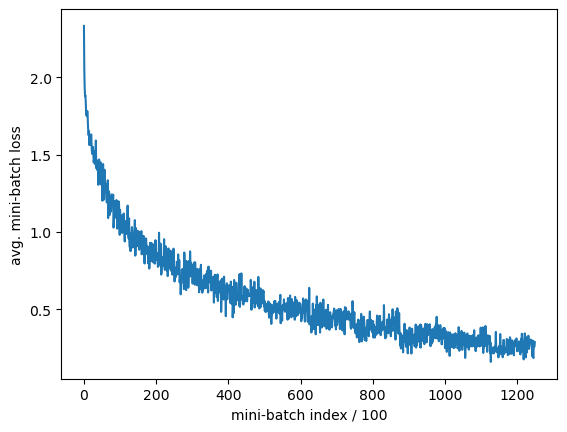

In [22]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [23]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 84 %


In [24]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 93 %
Accuracy of   car : 92 %
Accuracy of  bird : 81 %
Accuracy of   cat : 71 %
Accuracy of  deer : 78 %
Accuracy of   dog : 64 %
Accuracy of  frog : 91 %
Accuracy of horse : 87 %
Accuracy of  ship : 88 %
Accuracy of truck : 91 %


## Default Pooling + Sigmoid

In [25]:
alexnet = models.alexnet(pretrained=True)
num_classes = 10
alexnet.classifier[6] = nn.Linear(alexnet.classifier[6].in_features, num_classes)

def replace_relu_with_sigmoid(model):
    for name, module in model.named_children():
        # Replace ReLu with Sigmoid
        if isinstance(module, nn.ReLU):
            setattr(model, name, nn.Sigmoid())
        
        # Module is Sequential block or has children, replace it recursively
        elif isinstance(module, nn.Sequential):
            for i, sub_module in enumerate(module):
                if isinstance(sub_module, nn.ReLU):
                    module[i] = nn.Sigmoid()
                else:
                    replace_relu_with_sigmoid(sub_module)  # Recursively for children
        else:
            replace_relu_with_sigmoid(module)

replace_relu_with_sigmoid(alexnet)

new_features = []

#Modify to add the GroupNorm to the alexnet after conv2d layer
for layer in alexnet.features:
    new_features.append(layer)
    # If the layer is conv2d, add GroupNorm
    if isinstance(layer, nn.Conv2d):
        new_features.append(group_norm_layer(layer.out_channels))

#Replace the original with the modified features
alexnet.features = nn.Sequential(*new_features)

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
alexnet.to(device)

cuda:0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): GroupNorm(8, 64, eps=1e-05, affine=True)
    (2): Sigmoid()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): GroupNorm(8, 192, eps=1e-05, affine=True)
    (6): Sigmoid()
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): GroupNorm(8, 384, eps=1e-05, affine=True)
    (10): Sigmoid()
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): GroupNorm(8, 256, eps=1e-05, affine=True)
    (13): Sigmoid()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): GroupNorm(8, 256, eps=1e-05, affine=True)
    (16): Sigmoid()
    (17): MaxPool2d(kernel_size=3, stride=2, padding=0, di

In [27]:
# Use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# Use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9) 

In [28]:
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = alexnet(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 2.744
[epoch: 0, i:   199] avg mini-batch loss: 2.593
[epoch: 0, i:   299] avg mini-batch loss: 2.507
[epoch: 0, i:   399] avg mini-batch loss: 2.452
[epoch: 0, i:   499] avg mini-batch loss: 2.475
[epoch: 0, i:   599] avg mini-batch loss: 2.418
[epoch: 0, i:   699] avg mini-batch loss: 2.395
[epoch: 0, i:   799] avg mini-batch loss: 2.365
[epoch: 0, i:   899] avg mini-batch loss: 2.386
[epoch: 0, i:   999] avg mini-batch loss: 2.375
[epoch: 0, i:  1099] avg mini-batch loss: 2.355
[epoch: 0, i:  1199] avg mini-batch loss: 2.336
[epoch: 0, i:  1299] avg mini-batch loss: 2.359
[epoch: 0, i:  1399] avg mini-batch loss: 2.342
[epoch: 0, i:  1499] avg mini-batch loss: 2.318
[epoch: 0, i:  1599] avg mini-batch loss: 2.331
[epoch: 0, i:  1699] avg mini-batch loss: 2.327
[epoch: 0, i:  1799] avg mini-batch loss: 2.328
[epoch: 0, i:  1899] avg mini-batch loss: 2.329
[epoch: 0, i:  1999] avg mini-batch loss: 2.332
[epoch: 0, i:  2099] avg mini-batch loss

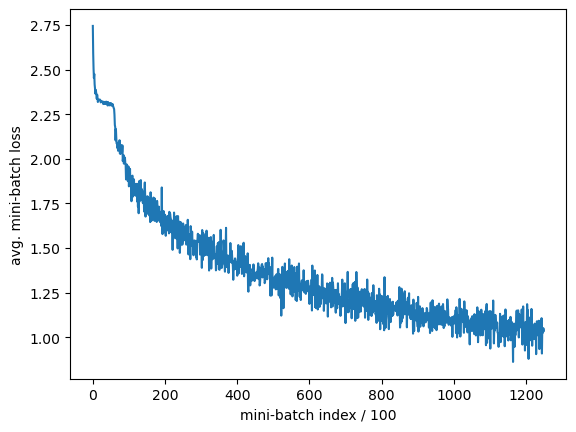

In [29]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [30]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 62 %


In [31]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 58 %
Accuracy of   car : 89 %
Accuracy of  bird : 35 %
Accuracy of   cat : 33 %
Accuracy of  deer : 55 %
Accuracy of   dog : 56 %
Accuracy of  frog : 66 %
Accuracy of horse : 79 %
Accuracy of  ship : 76 %
Accuracy of truck : 70 %


## Average Pooling + Sigmoid

In [8]:
alexnet = models.alexnet(pretrained=True)
num_classes = 10
alexnet.classifier[6] = nn.Linear(alexnet.classifier[6].in_features, num_classes)
#switch to average pooling
for i, layer in enumerate(alexnet.features):
    if isinstance(layer, nn.MaxPool2d):
        alexnet.features[i] = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)

#replace with sigmoid activation function
def replace_relu_with_sigmoid(model):
    for name, module in model.named_children():
        # Replace ReLu with Sigmoid
        if isinstance(module, nn.ReLU):
            setattr(model, name, nn.Sigmoid())
        
        # Module is Sequential block or has children, replace it recursively
        elif isinstance(module, nn.Sequential):
            for i, sub_module in enumerate(module):
                if isinstance(sub_module, nn.ReLU):
                    module[i] = nn.Sigmoid()
                else:
                    replace_relu_with_sigmoid(sub_module)  # Recursively for children
        else:
            replace_relu_with_sigmoid(module)

replace_relu_with_sigmoid(alexnet)

new_features = []

#Modify to add the GroupNorm to the alexnet after conv2d layer
for layer in alexnet.features:
    new_features.append(layer)
    # If the layer is conv2d, add GroupNorm
    if isinstance(layer, nn.Conv2d):
        new_features.append(group_norm_layer(layer.out_channels))

#Replace the original with the modified features
alexnet.features = nn.Sequential(*new_features)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
alexnet.to(device)

cuda:0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): GroupNorm(8, 64, eps=1e-05, affine=True)
    (2): Sigmoid()
    (3): AvgPool2d(kernel_size=3, stride=2, padding=1)
    (4): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): GroupNorm(8, 192, eps=1e-05, affine=True)
    (6): Sigmoid()
    (7): AvgPool2d(kernel_size=3, stride=2, padding=1)
    (8): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): GroupNorm(8, 384, eps=1e-05, affine=True)
    (10): Sigmoid()
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): GroupNorm(8, 256, eps=1e-05, affine=True)
    (13): Sigmoid()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): GroupNorm(8, 256, eps=1e-05, affine=True)
    (16): Sigmoid()
    (17): AvgPool2d(kernel_size=3, stride=2, padding=1)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (cl

In [10]:
# Use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# Use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9) 

In [11]:
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = alexnet(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 2.589
[epoch: 0, i:   199] avg mini-batch loss: 2.476
[epoch: 0, i:   299] avg mini-batch loss: 2.451
[epoch: 0, i:   399] avg mini-batch loss: 2.440
[epoch: 0, i:   499] avg mini-batch loss: 2.390
[epoch: 0, i:   599] avg mini-batch loss: 2.410
[epoch: 0, i:   699] avg mini-batch loss: 2.383
[epoch: 0, i:   799] avg mini-batch loss: 2.373
[epoch: 0, i:   899] avg mini-batch loss: 2.352
[epoch: 0, i:   999] avg mini-batch loss: 2.367
[epoch: 0, i:  1099] avg mini-batch loss: 2.358
[epoch: 0, i:  1199] avg mini-batch loss: 2.356
[epoch: 0, i:  1299] avg mini-batch loss: 2.341
[epoch: 0, i:  1399] avg mini-batch loss: 2.328
[epoch: 0, i:  1499] avg mini-batch loss: 2.344
[epoch: 0, i:  1599] avg mini-batch loss: 2.326
[epoch: 0, i:  1699] avg mini-batch loss: 2.327
[epoch: 0, i:  1799] avg mini-batch loss: 2.326
[epoch: 0, i:  1899] avg mini-batch loss: 2.306
[epoch: 0, i:  1999] avg mini-batch loss: 2.305
[epoch: 0, i:  2099] avg mini-batch loss

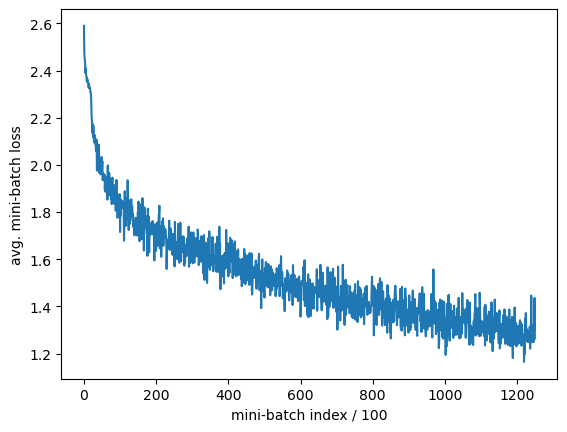

In [12]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [13]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 51 %


In [14]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 66 %
Accuracy of   car : 79 %
Accuracy of  bird : 44 %
Accuracy of   cat : 18 %
Accuracy of  deer : 35 %
Accuracy of   dog : 39 %
Accuracy of  frog : 77 %
Accuracy of horse : 43 %
Accuracy of  ship : 69 %
Accuracy of truck : 37 %
